<a href="https://colab.research.google.com/github/Orangefox76200/CapsNet-LSTM/blob/main/CapsNet_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Time Series Forecasting Using A Hybrid CapsNet-LSTM Architecture: Using real world data (DJIA Index)

DJIA Index dataset contains data of the daily DJIA Index price recorded from Jan 1st, 2010 to Dec 31st, 2019. In addition to be using Tensorflow's layers for processing sequence data such as LSTMs we will also intergrate Capsule Network in our proposed hybrid architecture to improve the model's performance.

Let's get started!

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 43.7 MB/s 


In [ ]:
import keras.backend as K
import tensorflow as tf
import keras
import keras_tuner
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [ ]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
print(tf.__version__)

2.8.2


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [ ]:
from google.colab import drive
drive.mount ('gdrive')
DJIA_raw = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/DJIA.xlsx')
DJIA_raw

Mounted at gdrive


,Date,Open,High,Low,Close,Volume
0,"Jan 04, 2010",10430.69,10604.97,10430.69,10583.96,179780000
1,"Jan 05, 2010",10584.56,10584.56,10522.52,10572.02,188540000
2,"Jan 06, 2010",10564.72,10594.99,10546.55,10573.68,186040000
3,"Jan 07, 2010",10571.11,10612.37,10505.21,10606.86,217390000
4,"Jan 08, 2010",10606.40,10619.40,10554.33,10618.19,172710000
...,...,...,...,...,...,...
2511,"Dec 24, 2019",28572.57,28576.80,28503.21,28515.45,86150000
2512,"Dec 26, 2019",28539.46,28624.10,28535.15,28621.39,155970000
2513,"Dec 27, 2019",28675.34,28701.66,28608.98,28645.26,182280000
2514,"Dec 30, 2019",28654.76,28664.69,28428.98,28462.14,181600000


In [ ]:
series = DJIA_raw.iloc[:,4]

In [ ]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

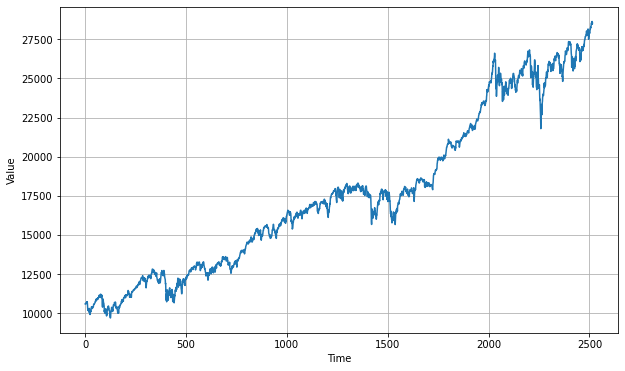

In [ ]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int((len(series)-150)*0.8)
    WINDOW_SIZE = 250
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 60

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

The `train_val_split` and `windowed_dataset` functions:

In [ ]:
def train_val_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:-150]
    series_valid = series[time_step:-150]
    time_test = time[-150:]
    series_test = series[-150:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

# Split the dataset
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_test_split(G.TIME, G.SERIES)

min-max normalization:

In [ ]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [ ]:
series_norm = min_max_normalization(G.SERIES)

In [ ]:
series_train_norm = series_norm[:G.SPLIT_TIME]
series_valid_norm = series_norm[G.SPLIT_TIME:-150]
series_test_norm = series_norm[-150:]

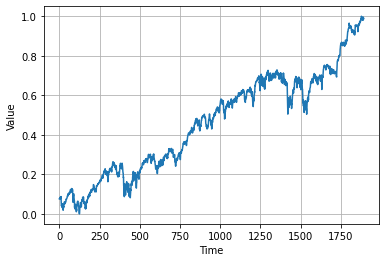

In [ ]:
plot_series(time_train, series_train_norm)

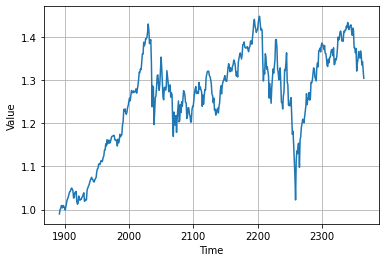

In [ ]:
plot_series(time_valid, series_valid_norm)

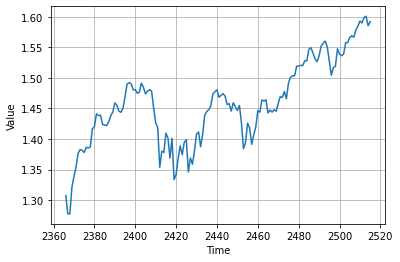

In [ ]:
plot_series(time_test, series_test_norm)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
# create val_set without using shuffle method.
def windowed_dataset_noshuffle(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


val_set = windowed_dataset_noshuffle(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [ ]:
train_val_set = windowed_dataset(series_norm[0:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Compiling the model


## Defining the model architecture (CapsNet-LSTM)


In [ ]:
# Squash function


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [ ]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)


    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

        #super().build(input_shape)
        #self.built = True
    

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(44).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [ ]:
input_shape = (G.WINDOW_SIZE, 1)

In [ ]:
K.clear_session()

### Tune hyper-parameters

In [ ]:
def build_CapsNet_LSTM(hp):
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=hp.Int('Conv1_units', 256, 1024, 256), kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
    conv1d_2 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='causal',name = 'conv1d_2')(conv1d_1)

    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 64, 8))(conv1d_2)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 512, routings = hp.Int('routings', 3, 5, 1)))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(hp.Int('lstm_units', 150, 300, 50))(conv1d_2)

    # Dense layer
    dense1 = tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu")(lstm)
    dense2 = tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu")(dense1)
    output = tf.keras.layers.Dense(1)(dense2)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_CapsNet_LSTM(keras_tuner.HyperParameters())

tuner_capsnet_lstm = keras_tuner.Hyperband(
    hypermodel=build_CapsNet_LSTM,
    objective="val_mae",
    max_epochs=2,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    directory="capsnet_lstm_results_dir",
    project_name="capsnet_lstm",
    overwrite=True)

tuner_capsnet_lstm.search(train_set, epochs=2, validation_data=val_set)

tuner_capsnet_lstm.results_summary()

# Get the top 2 hyperparameters.
best_hps_capsnet_lstm = tuner_capsnet_lstm.get_best_hyperparameters(5)
# Build the model with the best hp.
with strategy.scope():
  capsnet_lstm = build_CapsNet_LSTM(best_hps_capsnet_lstm[0])
# Fit with the entire dataset.
capsnet_lstm.fit(train_val_set, epochs=50)

Trial 2 Complete [00h 00m 29s]
val_mae: 0.0537913553416729

Best val_mae So Far: 0.0537913553416729
Total elapsed time: 00h 01m 00s
Results summary
Results in capsnet_lstm_results_dir/capsnet_lstm
Showing 10 best trials
Trial summary
Hyperparameters:
Conv1_units: 256
routings: 4
lstm_units: 250
dense1_units: 30
dense2_units: 20
lr: 0.0005275332628165129
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0537913553416729
Trial summary
Hyperparameters:
Conv1_units: 1024
routings: 3
lstm_units: 250
dense1_units: 30
dense2_units: 10
lr: 0.003188243137432297
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.16025054454803467
Epoch 1/50
67/67 [==============================] - 15s 122ms/step - loss: 0.0012 - mae: 0.0365
Epoch 2/50
67/67 [==============================] - 7s 100ms/step - loss: 5.6618e-04 - mae: 0.0268
Epoch 3/50
67/67 [==============================] - 6s 92ms/step - loss: 3.6677e-04 - mae: 0.0210
Epoch 4/50
67/67 [==

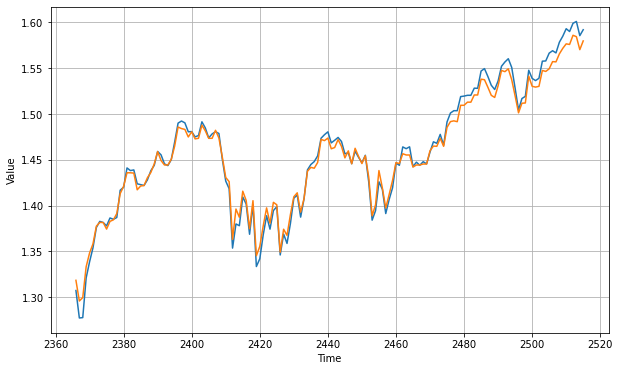

In [ ]:
# Compute the forecast for all the series
capsnet_lstm_forecast = model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat = capsnet_lstm_forecast[-150:]
# reverse normalization
# series_test_hat = reverse_normalization(cnn_lstm_forecast)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test_norm)
plot_series(time_test, series_test_hat)

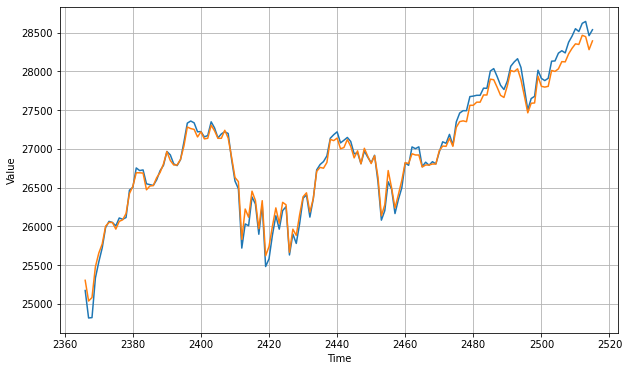

In [ ]:
series_test_hat = reverse_normalization(series_test_hat)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat)

In [ ]:
mse, mae = compute_metrics(series_test, series_test_hat)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 8236.04, mae: 73.33 for forecast


### Build CapsNet-LSTM

In [ ]:
# Adopt the optimal hyper-parameters
def CapsNet_LSTM(input_shape = (G.WINDOW_SIZE, 1), input_num_capsule =64, input_dim_capsule =8, dim_capsule = 512, routings =4):
    
      input = tf.keras.layers.Input(shape=input_shape)
      
      # First layer
      conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
      # Primary caps
      conv1d_2 = tf.keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, padding='causal',name = 'conv1d_2')(conv1d_1)
      
      unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, input_num_capsule, input_dim_capsule))(conv1d_2)
      #squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

      # Digit caps

      digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = dim_capsule, routings = routings))(unsquashed_caps)

      # LSTM layer
      lstm = tf.keras.layers.LSTM(250)(digit_caps)

      # Dense layer
      dense1 = tf.keras.layers.Dense(30, activation="relu")(lstm)
      dense2 = tf.keras.layers.Dense(20, activation="relu")(dense1)
      output = tf.keras.layers.Dense(1)(dense2)

      model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

      model.summary()   
      return model

In [ ]:
with strategy.scope():
  
  capsnet_lstm = CapsNet_LSTM(input_shape)
  capsnet_lstm.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.000527), metrics=["mae"])

# Fit with the entire dataset.
history = capsnet_lstm.fit(train_set, epochs=200, validation_data = val_set)

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 256)          768       
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 512)          262656    
                                                                 
 reshape_3 (Reshape)         (None, 250, 64, 8)        0         
                                                                 
 time_distributed_3 (TimeDis  (None, 250, 512)         262144    
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 250)               763000    
                                                      

### Training Curve

In [1]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

### Re-train using train_val_set 
train_set and val_set combine without shuffle:

In [ ]:
with strategy.scope():
  
  capsnet_lstm = CapsNet_LSTM(input_shape)
  capsnet_lstm.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.000527), metrics=["mae"])

# Fit with the entire dataset.
capsnet_lstm.fit(train_val_set, epochs=200)

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function that you coded in a previous assignment:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

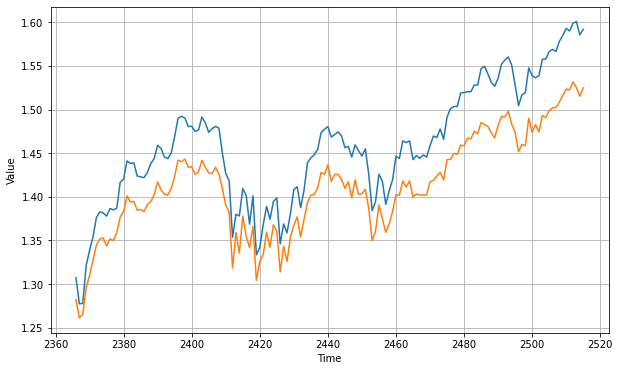

In [ ]:
# Compute the forecast for all the series
capsnet_lstm_forecast = model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat = capsnet_lstm_forecast[-150:]
# reverse normalization
# series_test_hat = reverse_normalization(cnn_lstm_forecast)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test_norm)
plot_series(time_test, series_test_hat)

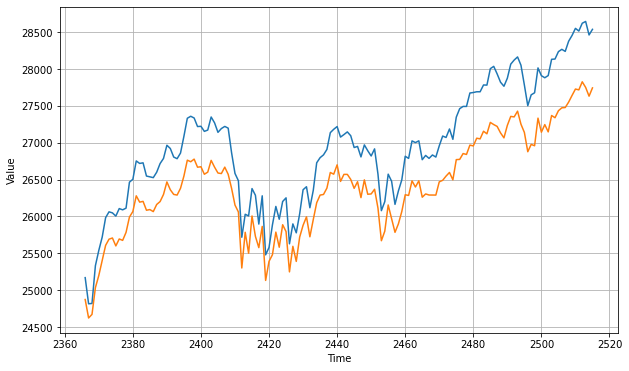

In [ ]:
series_test_hat = reverse_normalization(series_test_hat)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat)

In [ ]:
mse, mae = compute_metrics(series_test, series_test_hat)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 312870.38, mae: 539.23 for forecast


## Baseline (LSTM, CNN-LSTM)

### LSTM

In [ ]:
def build_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50), input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_LSTM(keras_tuner.HyperParameters())

tuner_lstm = keras_tuner.Hyperband(
    hypermodel=build_LSTM,
    objective="val_mae",
    max_epochs=2,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    directory="lstm_results_dir",
    project_name="lstm",
    overwrite=True)

tuner_lstm.search(train_set, epochs=2, validation_data=val_set)

tuner_lstm.results_summary()

# Get the top 2 hyperparameters.
best_hps_lstm = tuner_lstm.get_best_hyperparameters(5)
# Build the model with the best hp.
with strategy.scope():
  lstm = build_LSTM(best_hps_lstm[0])
# Fit with the entire dataset.
lstm.fit(train_val_set, epochs=200)

Trial 2 Complete [00h 00m 17s]
val_mae: 0.043499890714883804

Best val_mae So Far: 0.030787594616413116
Total elapsed time: 00h 00m 34s
Results summary
Results in lstm_results_dir/lstm
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 150
dense1_units: 40
dense2_units: 15
lr: 0.0021991663813950377
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.030787594616413116
Trial summary
Hyperparameters:
lstm_units: 250
dense1_units: 20
dense2_units: 10
lr: 0.00015485142777119614
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.043499890714883804
Epoch 1/100
67/67 [==============================] - 8s 46ms/step - loss: 0.0017 - mae: 0.0404
Epoch 2/100
67/67 [==============================] - 2s 28ms/step - loss: 0.0017 - mae: 0.0426
Epoch 3/100
67/67 [==============================] - 2s 28ms/step - loss: 0.0013 - mae: 0.0323
Epoch 4/100
67/67 [==============================] - 2s 29ms/step - loss: 8.1811e-04 - mae: 0.

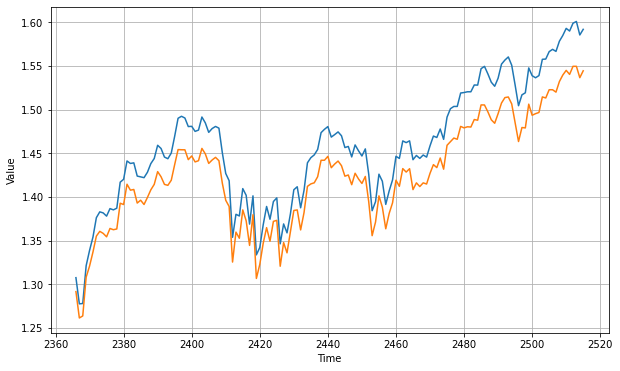

In [ ]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_lstm = lstm_forecast[-150:]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test_norm)
plot_series(time_test, series_test_hat_lstm)

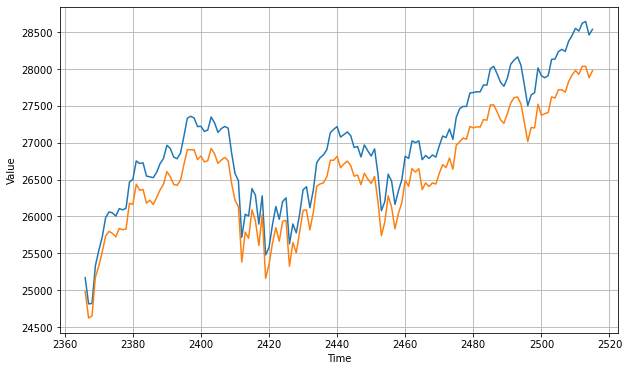

In [ ]:
series_test_hat_lstm = reverse_normalization(series_test_hat_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat_lstm)

In [ ]:
mse, mae = compute_metrics(series_test, series_test_hat_lstm)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 158680.19, mae: 386.56 for forecast


### CNN-LSTM

In [ ]:
def build_CNN_LSTM(hp):
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=hp.Int('Conv_units', 256, 1024, 256), kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(hp.Int('lstm_units', 100, 300, 50)),
          tf.keras.layers.Dense(hp.Int('dense1_units', 20, 50, step = 10), activation="relu"),
          tf.keras.layers.Dense(hp.Int('dense2_units', 5, 20, step = 5), activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])

    return model

In [ ]:
build_CNN_LSTM(keras_tuner.HyperParameters())

tuner_cnn_lstm = keras_tuner.Hyperband(
    hypermodel=build_CNN_LSTM,
    objective="val_mae",
    max_epochs=2,
    factor=3,
    hyperband_iterations=1,
    distribution_strategy=strategy,
    directory="cnn_lstm_results_dir",
    project_name="cnn-lstm",
    overwrite=True)


tuner_cnn_lstm.search(train_set, epochs=2, validation_data=val_set)

tuner_cnn_lstm.results_summary()

# Get the top 2 hyperparameters.
best_hps_cnn_lstm = tuner_cnn_lstm.get_best_hyperparameters(5)
# Build the model with the best hp.
with strategy.scope():
  cnn_lstm = build_LSTM(best_hps_cnn_lstm[0])
# Fit with the entire dataset.
cnn_lstm.fit(train_val_set, epochs=200)

Trial 2 Complete [00h 00m 23s]
val_mae: 0.21456332504749298

Best val_mae So Far: 0.10423777252435684
Total elapsed time: 00h 00m 49s
Results summary
Results in cnn_lstm_results_dir/cnn-lstm
Showing 10 best trials
Trial summary
Hyperparameters:
Conv_units: 768
lstm_units: 300
dense1_units: 30
dense2_units: 20
lr: 0.00018924314686241615
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10423777252435684
Trial summary
Hyperparameters:
Conv_units: 768
lstm_units: 150
dense1_units: 50
dense2_units: 10
lr: 0.009770890999581843
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.21456332504749298
Epoch 1/100
67/67 [==============================] - 10s 53ms/step - loss: 0.0069 - mae: 0.0939
Epoch 2/100
67/67 [==============================] - 2s 32ms/step - loss: 0.0022 - mae: 0.0536
Epoch 3/100
67/67 [==============================] - 2s 33ms/step - loss: 0.0017 - mae: 0.0477
Epoch 4/100
67/67 [==============================] - 2s 33

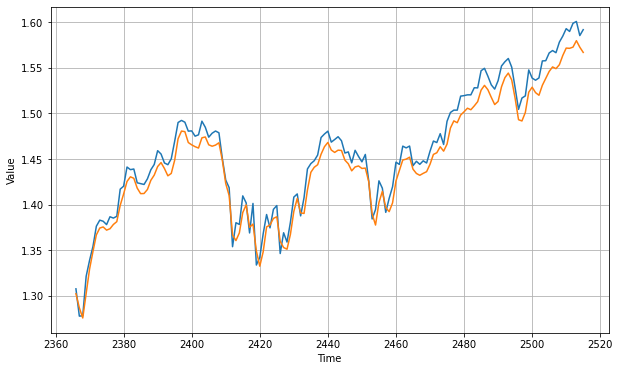

In [ ]:
# Compute the forecast for all the series
cnn_lstm_forecast = model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat_cnn_lstm = cnn_lstm_forecast[-150:]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test_norm)
plot_series(time_test, series_test_hat_cnn_lstm)

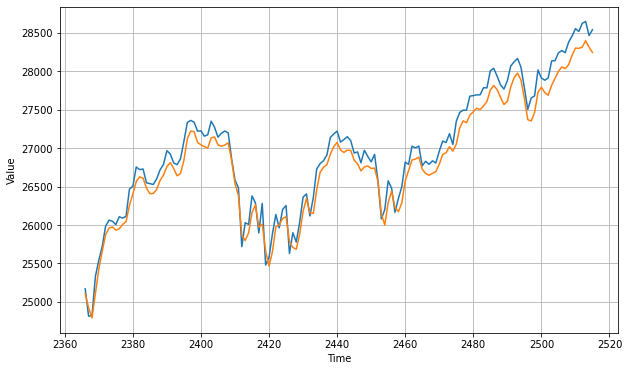

In [ ]:
series_test_hat_cnn_lstm = reverse_normalization(series_test_hat_cnn_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat_cnn_lstm)

In [ ]:
mse, mae = compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29937.43, mae: 159.06 for forecast


## Camparison

Compare our proposed capsnet_lstm with lstm and cnn-lstm

### Three forecasting results in one figure:

### Compare the rmse, mae mape